In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau,TensorBoard,ModelCheckpoint,EarlyStopping

In [2]:
#import dataset from data.csv file
dataset = pd.read_csv('electricity_demand.csv')
dataset.head()

,date,demand,RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,1/1/2015,99635.030,25.633696,13.3,5.186521,0.000000,0.0,N,Y
1,1/2/2015,129606.010,33.138988,15.4,6.228965,0.880597,0.0,N,N
2,1/3/2015,142300.540,34.564855,20.0,6.180615,1.011321,0.0,N,N
3,1/4/2015,104330.715,25.005560,16.3,4.626013,1.051587,4.2,N,N
4,1/5/2015,118132.200,26.724176,15.0,4.690416,0.820847,0.0,N,N


In [3]:
#Dataset correlation matrix
corrmat = dataset.corr()
corrmat.style.background_gradient(cmap='Blues').set_precision(2)

,demand,RRP,min_temperature,max_temperature,solar_exposure,rainfall
demand,1.00,0.23,-0.15,-0.12,0.04,-0.07
RRP,0.23,1.00,0.06,0.13,-0.01,-0.03
min_temperature,-0.15,0.06,1.00,0.71,0.19,0.00
max_temperature,-0.12,0.13,0.71,1.00,0.05,-0.16
solar_exposure,0.04,-0.01,0.19,0.05,1.00,-0.02
rainfall,-0.07,-0.03,0.00,-0.16,-0.02,1.00


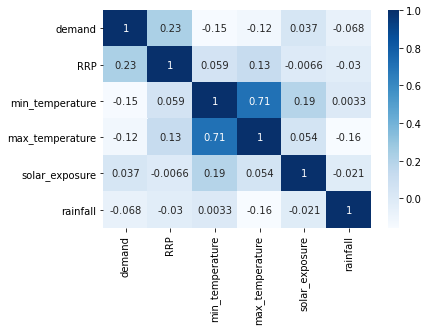

In [4]:
sns.heatmap(dataset.corr(), annot=True, cmap = 'Blues')
plt.show()

In [5]:
#Check for NA/Missing values
dataset.isnull().sum(axis = 0)

date               0
demand             0
RRP                0
min_temperature    0
max_temperature    0
solar_exposure     0
rainfall           0
school_day         0
holiday            0
dtype: int64

In [6]:
#Check for rows in a column
dataset.count()

date               2251
demand             2251
RRP                2251
min_temperature    2251
max_temperature    2251
solar_exposure     2251
rainfall           2251
school_day         2251
holiday            2251
dtype: int64

C:\Users\patel\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='demand'>

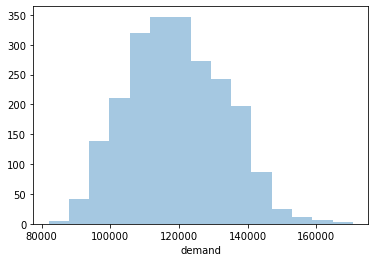

In [7]:
#Histogram of 'demand'
sns.distplot(dataset.demand.dropna(),kde = False, bins = 15)

In [8]:
#Format 'date' column 
dataset['date'] = pd.to_datetime(dataset['date'], infer_datetime_format=True)

<AxesSubplot:xlabel='date'>

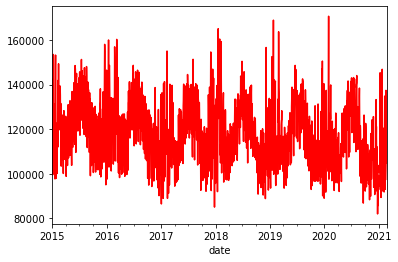

In [9]:
#Plot the 'demand' using date column
dataset.set_index('date')['demand'].plot(color='red')

In [10]:
#Set 'date' as index
dataset.set_index('date', inplace=True)

In [11]:
#Replace 'Y' with 1 and 'N' with 0
dataset['school_day'] = dataset['school_day'].replace(to_replace ="N", value = 0)
dataset['school_day'] = dataset['school_day'].replace(to_replace ="Y", value = 1)
dataset['holiday'] = dataset['holiday'].replace(to_replace ="N", value = 0)
dataset['holiday'] = dataset['holiday'].replace(to_replace ="Y", value = 1)

In [12]:
dataset.head()

,demand,RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
date,,,,,,,,
2015-01-01,99635.030,25.633696,13.3,5.186521,0.000000,0.0,0,1
2015-01-02,129606.010,33.138988,15.4,6.228965,0.880597,0.0,0,0
2015-01-03,142300.540,34.564855,20.0,6.180615,1.011321,0.0,0,0
2015-01-04,104330.715,25.005560,16.3,4.626013,1.051587,4.2,0,0
2015-01-05,118132.200,26.724176,15.0,4.690416,0.820847,0.0,0,0


In [13]:
#Split dataset into train and test
train_set = dataset.iloc[:2191]
train_set_target = train_set['demand']
train_set = train_set.drop(columns=['demand'])

test_set = dataset.iloc[2192:]
test_set_target = test_set['demand']
test_set = test_set.drop(columns=['demand'])

#Convert the series to dataframe
train_set_target = pd.DataFrame(train_set_target)
test_set_target = pd.DataFrame(test_set_target)

In [14]:
#Normalise the dataset 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
train_set = scaler.fit_transform(train_set)
test_set = scaler.fit_transform(test_set)

train_set_target = scaler_y.fit_transform(train_set_target)
test_set_target = scaler_y.fit_transform(test_set_target)

In [15]:
print(train_set.shape)
print(train_set_target.shape)
print(test_set.shape)
print(test_set_target.shape)

(2191, 7)
(2191, 1)
(59, 7)
(59, 1)


In [16]:
train_set = np.reshape(train_set, (train_set.shape[0], 1, train_set.shape[1]))
test_set = np.reshape(test_set, (test_set.shape[0], 1, test_set.shape[1]))

In [17]:
print(train_set.shape)
print(train_set_target.shape)
print(test_set.shape)
print(test_set_target.shape)

(2191, 1, 7)
(2191, 1)
(59, 1, 7)
(59, 1)


In [18]:
# SimpleRNN model
model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(2191,7), activation="relu"))
model.add(Dense(500, activation="relu")) 
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2900      
_________________________________________________________________
dense (Dense)                (None, 500)               25500     
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 501       
Total params: 28,901
Trainable params: 28,901
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(x=train_set,y=train_set_target, epochs=500, batch_size=100, verbose=2)

Epoch 1/500
22/22 - 1s - loss: 0.1553
Epoch 2/500
22/22 - 0s - loss: 0.1232
Epoch 3/500
22/22 - 0s - loss: 0.1191
Epoch 4/500
22/22 - 0s - loss: 0.1128
Epoch 5/500
22/22 - 0s - loss: 0.1104
Epoch 6/500
22/22 - 0s - loss: 0.1075
Epoch 7/500
22/22 - 0s - loss: 0.1066
Epoch 8/500
22/22 - 0s - loss: 0.1025
Epoch 9/500
22/22 - 0s - loss: 0.1036
Epoch 10/500
22/22 - 0s - loss: 0.1006
Epoch 11/500
22/22 - 0s - loss: 0.0999
Epoch 12/500
22/22 - 0s - loss: 0.1023
Epoch 13/500
22/22 - 0s - loss: 0.0977
Epoch 14/500
22/22 - 0s - loss: 0.0983
Epoch 15/500
22/22 - 0s - loss: 0.0962
Epoch 16/500
22/22 - 0s - loss: 0.0973
Epoch 17/500
22/22 - 0s - loss: 0.0963
Epoch 18/500
22/22 - 0s - loss: 0.0964
Epoch 19/500
22/22 - 0s - loss: 0.0955
Epoch 20/500
22/22 - 0s - loss: 0.0947
Epoch 21/500
22/22 - 0s - loss: 0.0939
Epoch 22/500
22/22 - 0s - loss: 0.0939
Epoch 23/500
22/22 - 0s - loss: 0.0945
Epoch 24/500
22/22 - 0s - loss: 0.0941
Epoch 25/500
22/22 - 0s - loss: 0.0939
Epoch 26/500
22/22 - 0s - loss: 0.

In [20]:
#Predict electricity demand for train and test dataset
train_pred = model.predict(train_set)
test_pred = model.predict(test_set)

In [21]:
print(train_pred.shape)
print(test_pred.shape)

(2191, 1)
(59, 1)


In [22]:
#Apply inverse transformation to predictions
train_pred = scaler_y.inverse_transform(train_pred)
train_set_target = scaler_y.inverse_transform(train_set_target)
test_pred = scaler_y.inverse_transform(test_pred)
test_set_target = scaler_y.inverse_transform(test_set_target)

In [23]:
trainScore = model.evaluate(train_set, train_set_target, verbose=0)
print(trainScore)

113683.6171875


In [24]:
#Import the relevant performance metric libraries 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from math import sqrt

In [25]:
print("Mean Absolute Error: ", mean_absolute_error(train_set_target[:,0], train_pred[:,0]))
print("Mean Absolute Percentage Error: ", np.mean(np.abs((train_set_target[:,0] - train_pred[:,0]) / train_set_target[:,0])) * 100)
print("Mean Squared Error: ", mean_squared_error(train_set_target[:,0], train_pred[:,0]))
print("Root Mean Squared Error: ", sqrt(mean_squared_error(train_set_target[:,0], train_pred[:,0])))
print("R2 Score: ", r2_score(train_set_target[:,0],train_pred[:,0]))

Mean Absolute Error:  4531.157705089514
Mean Absolute Percentage Error:  4.054740562676598
Mean Squared Error:  34299958.471545376
Root Mean Squared Error:  5856.616640309094
R2 Score:  0.5777914891292184


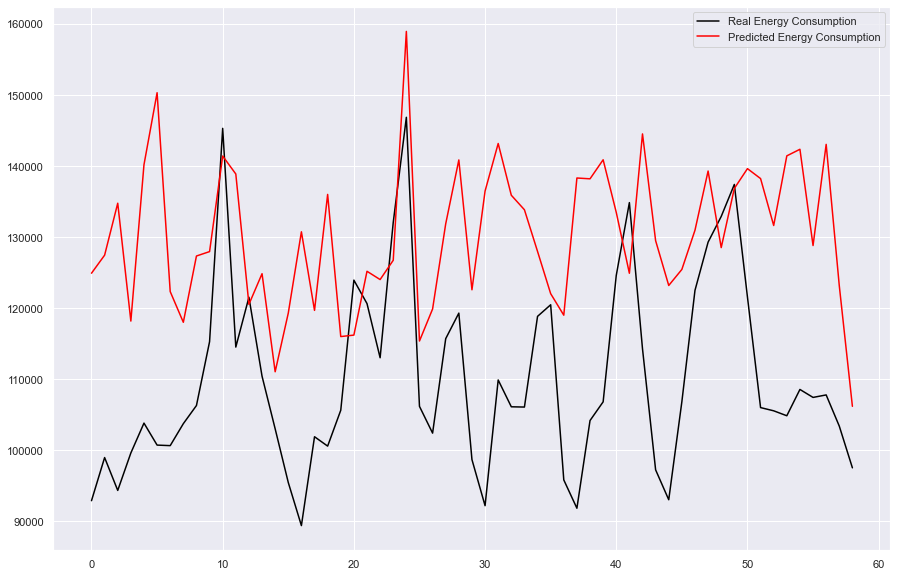

In [26]:
#Real vs predicted Energy Consumption
sns.set(rc={'figure.figsize':(15,10)})
plt.plot(test_set_target,color='black')
plt.plot(test_pred,color='red')
plt.legend(['Real Energy Consumption','Predicted Energy Consumption'])
plt.show()

In [27]:
Real_Demand = pd.DataFrame(test_set_target, columns = ['Real_Demand'], index = dataset.iloc[2192:].index)
Predicted_Demand = pd.DataFrame(test_pred, columns = ['Predict_Demand'], index = dataset.iloc[2192:].index)

In [28]:
#Combine the original demand and forecasted demand
output = pd.DataFrame()
output['Real_Demand'] = Real_Demand['Real_Demand']
output['Predicted_Demand'] = Predicted_Demand['Predict_Demand']

In [29]:
output.head()

,Real_Demand,Predicted_Demand
date,,
2021-01-01,92926.685,124928.921875
2021-01-02,98995.065,127469.914062
2021-01-03,94371.480,134777.359375
2021-01-04,99640.535,118197.984375
2021-01-05,103840.455,140190.390625


In [30]:
#Define train set
train_set = dataset.iloc[:]
train_set_target = train_set['demand']
train_set = train_set.drop(columns=['demand'])
train_set_target = pd.DataFrame(train_set_target)

In [31]:
print(train_set.shape)
print(train_set_target.shape)

(2251, 7)
(2251, 1)


In [32]:
#Obtain prediction dataset
predict_set = pd.read_csv('dataset_for_prediction.csv')
predict_set = predict_set.drop(columns=['demand'])
predict_set.head()

,date,RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,03-01-2021,16.113191,12.506416,20.844,14.810004,1.000000,Y,N
1,03-02-2021,20.828125,12.016535,20.244,15.744815,1.000000,Y,N
2,03-03-2021,24.979167,11.526654,19.144,15.494148,1.733333,Y,N
3,03-04-2021,24.135417,11.036772,16.892,13.976392,12.800000,Y,N
4,03-05-2021,21.580625,10.546891,16.680,13.893853,32.700000,Y,N


In [33]:
#Replace 'Y' with 1 and 'N' with 0
predict_set['school_day'] = predict_set['school_day'].replace(to_replace ="N", value = 0)
predict_set['school_day'] = predict_set['school_day'].replace(to_replace ="Y", value = 1)
predict_set['holiday'] = predict_set['holiday'].replace(to_replace ="N", value = 0)
predict_set['holiday'] = predict_set['holiday'].replace(to_replace ="Y", value = 1)

In [34]:
#Format 'date' column in the predict_set
predict_set['date'] = pd.to_datetime(predict_set['date'], infer_datetime_format=True)
predict_set.set_index('date', inplace=True)

In [35]:
predict_set.head()

,RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
date,,,,,,,
2021-03-01,16.113191,12.506416,20.844,14.810004,1.000000,1,0
2021-03-02,20.828125,12.016535,20.244,15.744815,1.000000,1,0
2021-03-03,24.979167,11.526654,19.144,15.494148,1.733333,1,0
2021-03-04,24.135417,11.036772,16.892,13.976392,12.800000,1,0
2021-03-05,21.580625,10.546891,16.680,13.893853,32.700000,1,0


In [36]:
#Normalise the dataset using MinMax scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
train_set = scaler.fit_transform(train_set)
predict_set = scaler.fit_transform(predict_set)

train_set_target = scaler_y.fit_transform(train_set_target)

In [37]:
train_set = np.reshape(train_set, (train_set.shape[0], 1, train_set.shape[1]))
predict_set = np.reshape(predict_set, (predict_set.shape[0], 1, predict_set.shape[1]))

print(train_set.shape)
print(predict_set.shape)

(2251, 1, 7)
(184, 1, 7)


In [38]:
# SimpleRNN model
model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(2251,7), activation="relu"))
model.add(Dense(8, activation="relu")) 
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 50)                2900      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 408       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 3,317
Trainable params: 3,317
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(x=train_set,y=train_set_target, epochs=500, batch_size=100, verbose=2)

Epoch 1/500
23/23 - 1s - loss: 0.4499
Epoch 2/500
23/23 - 0s - loss: 0.2124
Epoch 3/500
23/23 - 0s - loss: 0.1939
Epoch 4/500
23/23 - 0s - loss: 0.1802
Epoch 5/500
23/23 - 0s - loss: 0.1718
Epoch 6/500
23/23 - 0s - loss: 0.1668
Epoch 7/500
23/23 - 0s - loss: 0.1587
Epoch 8/500
23/23 - 0s - loss: 0.1600
Epoch 9/500
23/23 - 0s - loss: 0.1553
Epoch 10/500
23/23 - 0s - loss: 0.1496
Epoch 11/500
23/23 - 0s - loss: 0.1474
Epoch 12/500
23/23 - 0s - loss: 0.1429
Epoch 13/500
23/23 - 0s - loss: 0.1403
Epoch 14/500
23/23 - 0s - loss: 0.1339
Epoch 15/500
23/23 - 0s - loss: 0.1316
Epoch 16/500
23/23 - 0s - loss: 0.1292
Epoch 17/500
23/23 - 0s - loss: 0.1290
Epoch 18/500
23/23 - 0s - loss: 0.1280
Epoch 19/500
23/23 - 0s - loss: 0.1220
Epoch 20/500
23/23 - 0s - loss: 0.1244
Epoch 21/500
23/23 - 0s - loss: 0.1202
Epoch 22/500
23/23 - 0s - loss: 0.1182
Epoch 23/500
23/23 - 0s - loss: 0.1158
Epoch 24/500
23/23 - 0s - loss: 0.1172
Epoch 25/500
23/23 - 0s - loss: 0.1166
Epoch 26/500
23/23 - 0s - loss: 0.

In [40]:
predictions = model.predict(predict_set)

In [41]:
predictions = scaler_y.inverse_transform(predictions)

In [42]:
predict_set = pd.read_csv('dataset_for_prediction.csv')
predict_set['date'] = pd.to_datetime(predict_set['date'], infer_datetime_format=True)
predict_set.set_index('date', inplace=True)
predict_set['demand'] = predictions
predict_set.head()

,demand,RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
date,,,,,,,,
2021-03-01,146571.656250,16.113191,12.506416,20.844,14.810004,1.000000,Y,N
2021-03-02,134053.734375,20.828125,12.016535,20.244,15.744815,1.000000,Y,N
2021-03-03,128496.882812,24.979167,11.526654,19.144,15.494148,1.733333,Y,N
2021-03-04,113750.406250,24.135417,11.036772,16.892,13.976392,12.800000,Y,N
2021-03-05,112233.882812,21.580625,10.546891,16.680,13.893853,32.700000,Y,N


In [43]:
dataset.head()

,demand,RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
date,,,,,,,,
2015-01-01,99635.030,25.633696,13.3,5.186521,0.000000,0.0,0,1
2015-01-02,129606.010,33.138988,15.4,6.228965,0.880597,0.0,0,0
2015-01-03,142300.540,34.564855,20.0,6.180615,1.011321,0.0,0,0
2015-01-04,104330.715,25.005560,16.3,4.626013,1.051587,4.2,0,0
2015-01-05,118132.200,26.724176,15.0,4.690416,0.820847,0.0,0,0


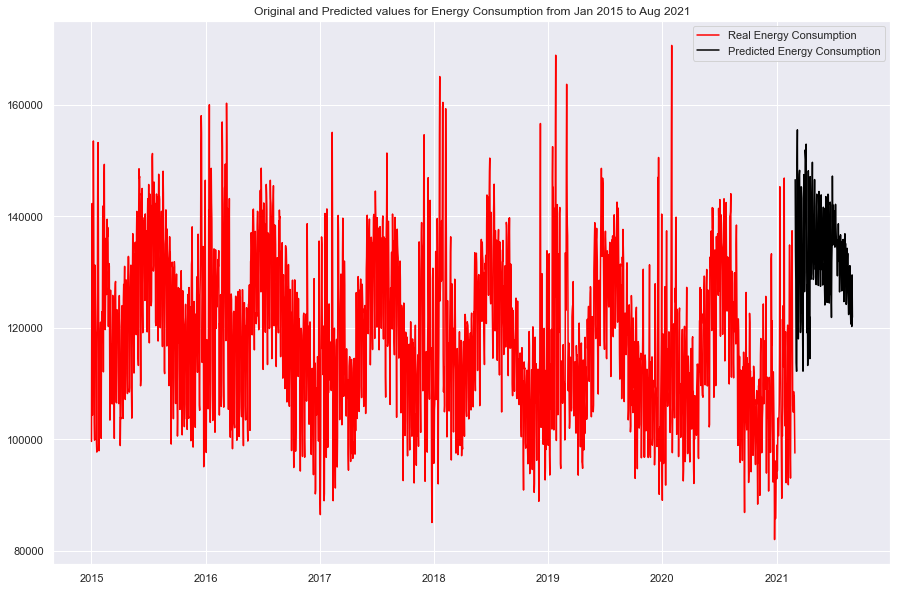

In [44]:
#Real vs predicted Energy Consumption (Jan 2015 - Aug 2021)
sns.set(rc={'figure.figsize':(15,10)})
plt.plot(dataset['demand'], color='red')
plt.plot(predict_set['demand'], color='black')
plt.legend(['Real Energy Consumption','Predicted Energy Consumption'])
plt.title("Original and Predicted values for Energy Consumption from Jan 2015 to Aug 2021")
plt.show()

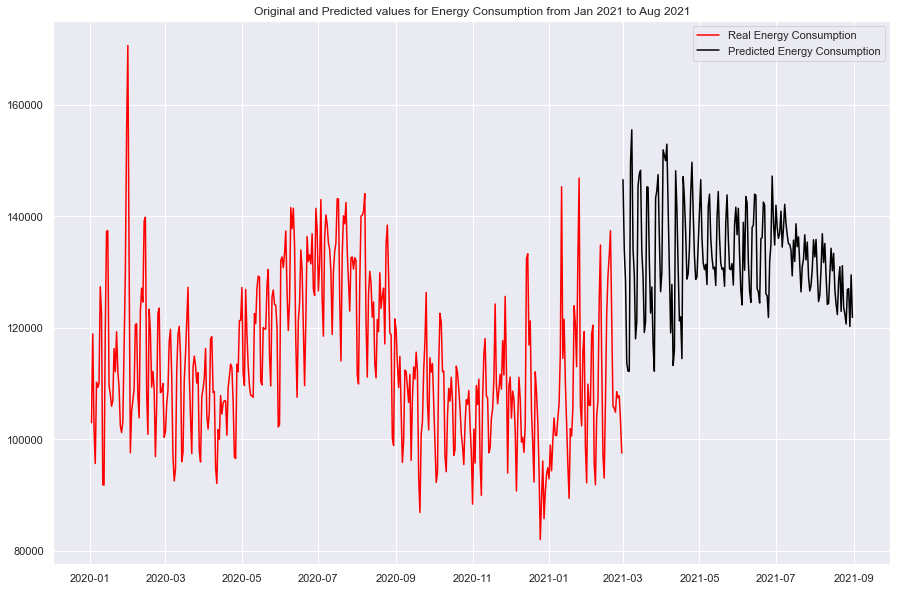

In [45]:
#Real vs predicted Energy Consumption (Jan 2020 - Aug 2021)
sns.set(rc={'figure.figsize':(15,10)})
plt.plot(dataset['demand'][-424:], color='red')
plt.plot(predict_set['demand'], color='black')
plt.legend(['Real Energy Consumption','Predicted Energy Consumption'])
plt.title("Original and Predicted values for Energy Consumption from Jan 2021 to Aug 2021")
plt.show()